<h2>Deep L layer Neural Network</h2>

In [290]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2

## Importing dataset

In [291]:
train_dataset = h5py.File('train_catvnoncat.h5', 'r')
test_dataset = h5py.File('test_catvnoncat.h5', 'r')

In [292]:
X_train_orig = train_dataset['train_set_x']
Y_train_orig = train_dataset['train_set_y']
X_test_orig = test_dataset['test_set_x']
Y_test_orig = test_dataset['test_set_y']

In [293]:
#Converting dataset to numpy array
X_train_orig = np.array(X_train_orig)
Y_train_orig = np.array(Y_train_orig)
X_test_orig = np.array(X_test_orig)
Y_test_orig = np.array(Y_test_orig)

In [294]:
#Flattening the dataset
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

In [295]:
#Standarizing the dataset
X_train_std = X_train_flatten/255.
X_test_std = X_test_flatten/255.

In [296]:
#Removing rank 1 matrix from Y dataset
Y_train = Y_train_orig.reshape(1, Y_train_orig.shape[0])
Y_test = Y_test_orig.reshape(1, Y_test_orig.shape[0])

In [297]:
#Printing the dataset to make sure the dimensions are ok
print('Size of X_train_std = '+str(X_train_std.shape))
print('Size of Y_train = '+str(Y_train.shape))
print('Size of X_test_std = '+str(X_test_std.shape))
print('Size of Y_test = '+str(Y_test.shape))

Size of X_train_std = (12288, 209)
Size of Y_train = (1, 209)
Size of X_test_std = (12288, 50)
Size of Y_test = (1, 50)


## Sigmoid function

In [299]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

In [300]:
def sigmoid_check(c):
    x = np.random.randn(1, c)
    r = -c*0.05
    for i in range(0, c):
        r = r+0.1
        x[0, i] = r
    x = x.reshape(c,)
    sigmoid_x, cache = sigmoid(x)
    sigmoid_x = sigmoid_x.reshape(c,)
    plt.plot(x, sigmoid_x)
    plt.xlabel('x')
    plt.ylabel('sigmoid(x)')
    plt.show()

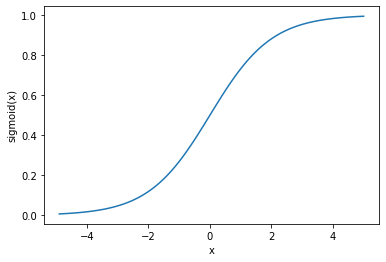

In [302]:
sigmoid_check(100)

## Sigmoid backward function

In [303]:
def sigmoid_backward(dA, activation_cache):
    Z = activation_cache
    sigmoid_Z, trash = sigmoid(Z)
    dZ = dA*(sigmoid_Z*(1-sigmoid_Z))
    assert(dZ.shape == Z.shape)
    return dZ

## Relu function

In [304]:
def relu(Z):
    #A = (Z+np.abs(Z))/2
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

In [305]:
def relu_check(c):
    x = np.random.randn(1, c)
    r = -c*0.05
    for i in range(0, c):
        r = r+0.1
        x[0, i] = r
    x = x.reshape(c,)
    relu_x, cache = relu(x)
    relu_x = relu_x.reshape(c,)
    plt.plot(x, relu_x)
    plt.xlabel('x')
    plt.ylabel('relu(x)')
    plt.show()

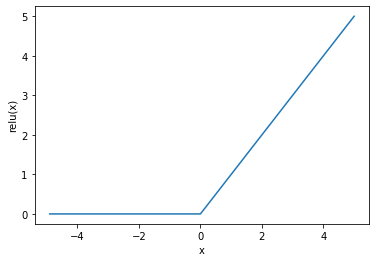

In [306]:
relu_check(100)

## Relu backward function

In [307]:
def relu_backward(dA, activation_cache):
    Z = activation_cache
    #dZ = dA*((1+np.divide(Z, np.abs(Z)))//2)
    dZ = np.array(dA, copy = True)
    dZ[Z<=0] = 0
    assert(dZ.shape == Z.shape)
    return dZ

## Initializing parameters

In [308]:
def initialize_parameters(layer_dims):
    parameters={}
    L=len(layer_dims)
    for l in range(1, L):
        parameters['W'+str(l)]=np.random.randn(layer_dims[l], layer_dims[l-1])/np.sqrt(layer_dims[l-1])
        parameters['b'+str(l)]=np.zeros((layer_dims[l], 1))
    return parameters

## Forward propagation

In [309]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache

In [310]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation=='relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache=relu(Z)
        #print('activation = relu')
    elif activation=='sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache=sigmoid(Z)
        #print('activation = sigmoid')
    cache = (linear_cache, activation_cache)
    return A, cache

In [311]:
def propagate_forward(X, parameters):
    L=len(parameters)//2
    caches = []
    A=X
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], activation = 'relu')
        caches.append(cache)
        #print('Layer = '+str(l)+' activation = relu')

    A_prev = A
    AL, cache = linear_activation_forward(A_prev, parameters['W'+str(L)], parameters['b'+str(L)], activation = 'sigmoid')
    caches.append(cache)
    #print('Layer = '+str(L)+' activation = sigmoid')
    return AL, caches

## Compute cost

In [312]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1./m)*(np.dot(Y, np.log(AL).T)+np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost)
    return cost
    

## Backward propagation

In [313]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1/m*np.dot(dZ, A_prev.T)
    db = 1/m*np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)
    assert(dA_prev.shape == A_prev.shape)
    
    return dW, db, dA_prev

In [314]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dW, db, dA_prev = linear_backward(dZ, linear_cache)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dW, db, dA_prev = linear_backward(dZ, linear_cache)
        
    return dW, db, dA_prev

In [315]:
def propagate_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    assert(AL.shape == Y.shape) 
    dAL = -np.divide(Y, AL)+np.divide((1-Y), (1-AL))
    
    current_cache = caches[L-1]
    grads['dW'+str(L)], grads['db'+str(L)], grads['dA'+str(L-1)] = linear_activation_backward(dAL, current_cache, activation = 'sigmoid')
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        grads['dW'+str(l+1)], grads['db'+str(l+1)], grads['dA'+str(l)] = linear_activation_backward(grads['dA'+str(l+1)], current_cache, activation = 'relu')
        
    return grads
    

## Gradient descent

In [316]:
def gradient_descent(parameters, grads, learning_rate):
    L = len(parameters)//2
    
    for l in range(L):
        parameters['W'+str(l+1)] = parameters['W'+str(l+1)] - learning_rate * grads['dW'+str(l+1)]
        parameters['b'+str(l+1)] = parameters['b'+str(l+1)] - learning_rate * grads['db'+str(l+1)]
        
    return parameters

## Building an L two layer model

In [317]:
def predict(parameters, X, Y):
    AL, caches = propagate_forward(X, parameters)
    for i in range(AL.shape[1]):
        if AL[0, i] > 0.5:
            AL[0, i] = 1
        else:
            AL[0, i] = 0
    return AL

In [318]:
def L_layer_model(X_train, Y_train, X_test, Y_test, layer_dims, learning_rate, iterations, print_cost):
    costs = []
    num_iterations = []
    parameters = initialize_parameters(layer_dims)
    for i in range(0, iterations):
        AL, caches = propagate_forward(X_train, parameters)
        cost = compute_cost(AL, Y_train)
        grads = propagate_backward(AL, Y_train, caches)
        parameters = gradient_descent(parameters, grads, learning_rate)
        if print_cost == True and i%100 == 0:
            costs.append(cost)
            num_iterations.append(i)
            print('Cost after iteration '+str(i)+' = '+str(cost))
        
    plt.plot(num_iterations, costs)
    plt.xlabel('Number of iterations')
    plt.ylabel('Cost')
    plt.title('Cost graph')
    plt.show()
    
    Y_pred_train = predict(parameters, X_train, Y_test)
    Y_pred_test = predict(parameters, X_test, Y_test)
    
    print('Train accuracy = {} %'.format(100-np.mean(np.abs(Y_pred_train-Y_train))*100))
    print('Test accuracy = {} %'.format(100-np.mean(np.abs(Y_pred_test-Y_test))*100))
    return parameters

Cost after iteration 0 = 0.6959971917395756
Cost after iteration 100 = 0.6778575032165973
Cost after iteration 200 = 0.6672020912237999
Cost after iteration 300 = 0.6596550664158684
Cost after iteration 400 = 0.65332275514949
Cost after iteration 500 = 0.6390046657671259
Cost after iteration 600 = 0.5847127922524491
Cost after iteration 700 = 0.5366424379365049
Cost after iteration 800 = 0.5276077656946592
Cost after iteration 900 = 0.47169302200768604
Cost after iteration 1000 = 0.4615979068350667
Cost after iteration 1100 = 0.40628087371133104
Cost after iteration 1200 = 0.378448143864189
Cost after iteration 1300 = 0.35008754678640425
Cost after iteration 1400 = 0.32497691870483025
Cost after iteration 1500 = 0.29837879860301353
Cost after iteration 1600 = 0.27727092150466826
Cost after iteration 1700 = 0.2474434227792599
Cost after iteration 1800 = 0.2203515019212012
Cost after iteration 1900 = 0.19872662432017646
Cost after iteration 2000 = 0.1811756202468384
Cost after iteration 

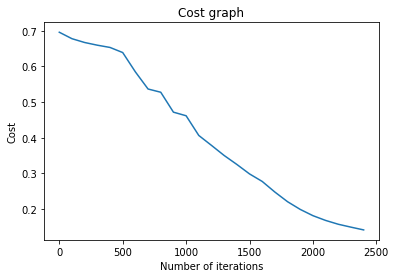

Train accuracy = 98.56459330143541 %
Test accuracy = 82.0 %


In [319]:
layer_dims = [12288, 20, 7, 5, 1]
parameters = L_layer_model(X_train_std, Y_train, X_test_std, Y_test, layer_dims, learning_rate = 0.0075, iterations = 2500, print_cost = True)

## Checking own image

It is not a cat


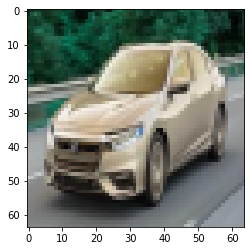

In [335]:
#Importing image
my_image = 'car2.jpg'
Y = [1] #write 1 if cat and 0 if non-cat


image = 'images/' + my_image
my_image = cv2.imread(image, 1)

resized_image = cv2.resize(my_image, (64, 64), interpolation = cv2.INTER_AREA)

#Converting image to numpy array
img = np.array(resized_image)
plt.imshow(img)

#Flattening the image
img_flatten = img.reshape(img.shape[0]*img.shape[1]*img.shape[2], 1)

#Standarizing the image
img_std = img_flatten/255

#Check image size (12288, 1)
img_std.shape

#Make prediciton
prediction = predict(parameters, img_std, Y)
if prediction == 1:
    print("It is a cat")
else:
    print("It is not a cat")
